In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
class LogisticGLMMLogPosterior(object):
    def __init__(
        self, glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec):

        self.glmm_par_draw = copy.deepcopy(glmm_par_draw)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.K = x_mat.shape[1]

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.glmm_par_draw['u'].size() - 1

    def get_log_prior(self):
        beta = self.glmm_par_draw['beta'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)
        
        cov_beta = np.zeros((self.K, self.K))
        beta_prior_info = self.prior_par['beta_prior_info'].get()
        beta_prior_mean = self.prior_par['beta_prior_mean'].get()
        log_p_beta = ef.mvn_prior(
            beta_prior_mean, beta_prior_info, beta, cov_beta)

        log_p_mu = ef.uvn_prior(
            self.prior_par['mu_prior_mean'].get(),
            self.prior_par['mu_prior_info'].get(), mu, 0.0)

        tau_prior_shape = self.prior_par['tau_prior_alpha'].get()
        tau_prior_rate = self.prior_par['tau_prior_beta'].get()
        log_p_tau = ef.gamma_prior(
            tau_prior_shape, tau_prior_rate, tau, log_tau)

        return log_p_beta + log_p_mu + log_p_tau

    def get_log_lik(self):
        beta = self.glmm_par_draw['beta'].get()
        u = self.glmm_par_draw['u'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)

        log_lik = 0.

        # Log likelihood from data.
        z = u[self.y_g_vec] + np.matmul(self.x_mat, beta)
        log_lik += np.sum(self.y_vec * z - np.log1p(np.exp(z)))

        # Log likelihood from random effect terms.
        log_lik += -0.5 * tau * np.sum((mu - u) ** 2) + 0.5 * log_tau * len(u)

        return log_lik

    def get_log_posterior(self):
        return np.squeeze(
            self.get_log_lik() + \
            self.get_log_prior())




In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-696.14718055994535

In [5]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        self.num_gh_points = 5
        self.model.set_gh_points(self.num_gh_points)
        
        self.get_weight_obs_jacobian = autograd.grad(
            self.get_data_log_lik_term)
        
        self.obs = 0
        
    def get_data_log_lik_term(self, free_par, obs):
        self.model.glmm_par.set_free(free_par)
        return logit_glmm.get_data_log_lik_terms(
                glmm_par = self.model.glmm_par,
                x_mat = np.atleast_2d(self.model.x_mat[obs, :]),
                y_vec = np.atleast_1d(self.model.y_vec[obs]),
                y_g_vec = np.atleast_1d(self.model.y_g_vec[obs]),
                gh_x = self.model.gh_x,
                gh_w = self.model.gh_w)[0]
    
    def get_weight_jacobian_list(self, free_par):
        weight_jacobian_list = []
        #np.full((self.model.x_mat.shape[0], len(free_par)), float('nan'))
        print('Running.')
        for obs in range(self.model.x_mat.shape[0]):
            if obs % 1000 == 0:
                print('Obs {}'.format(obs))
            weight_jacobian_list.append(self.get_weight_obs_jacobian(free_par, obs))
        print('Done.')
        return weight_jacobian_list
            
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()

    def optimize_with_weights(self, weights, init_par, preconditioner, gtol=1e-6, print_every=1):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.tr_optimize_cond(
            init_par, preconditioner=preconditioner,
            num_gh_points=self.num_gh_points, gtol=gtol, print_every=print_every)   
    
    def get_model_weight_grad(self, free_par_vec, weights):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.objective.fun_free_grad(free_par_vec)

    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
moment_jac = vb_data['moment_jac']
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)


(214, 214)


In [6]:
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
preconditioner = sp.sparse.diags([1 / np.sqrt(-1. * elbo_hess.diagonal())], [0])
cond_init = sp.sparse.linalg.spsolve(preconditioner, glmm_par_free)


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [7]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    weights=base_weights, init_par=cond_init, gtol=1e-8)
base_free_par = glmm_bootstrap_object.model.objective.uncondition_x(base_opt.x)

1000.0
Iter  0  value:  69.4079315229
Iter  1  value:  69.407924802
Iter  2  value:  69.4079246793
Iter  3  value:  69.4079246793
Optimization terminated successfully.
         Current function value: 69.407925
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0


In [8]:
moment_jac_time = time.time()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
moment_jac_time = time.time() - moment_jac_time

moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

print('Time: ', moment_jac_time)


Time:  0.0841829776763916


In [9]:
# Get a sparse Jacobian.
# sparse_model = logit_glmm.SparseModelObjective(
#     model.glmm_par, model.prior_par, model.x_mat, model.y_vec, model.y_g_vec,
#     num_gh_points=model.num_gh_points, num_groups=1)

# sparse_model.glmm_par.set_free(model.glmm_par.get_free())
jac_time = time.time()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=200)
jac_time = time.time() - jac_time

print('Jacobian time: ', jac_time)


Group 0 of 99
Jacobian time:  0.9509596824645996


In [10]:
hess_time = time.time()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=200)
hess_time = time.time() - hess_time

Group 0 of 99.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [17]:
# Too bad you can't pickle sparse cholesky decomposition.

from scikits.sparse.cholmod import cholesky

inverse_time = time.time()

print('Cholesky:')
kl_hess_chol = cholesky(kl_hess)

print('Solve:')
param_boot_mat = -1 * kl_hess_chol.solve_A(weight_jacobian.T)

print('Done.')

inverse_time = time.time() - inverse_time


Cholesky:
Solve:
Done.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


In [27]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = True
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[np.random.randint(NObs)] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_param_diff = param_boot_mat * (np.squeeze(boot_draw) - 1.0)

# Optionally, try taking a Newton step using the Hessian.
# model_weight_grad = glmm_bootstrap_object.get_model_weight_grad(
#     base_free_par + lr_param_diff, boot_draw)
# model_weight_grad_sp = sp.sparse.csc_matrix(np.expand_dims(model_weight_grad, axis=1))
# boot_newton_step_sp = kl_hess_chol.solve_A(model_weight_grad_sp)
# boot_newton_step = np.asarray(boot_newton_step_sp)
# print(np.max(np.abs(boot_newton_step)))

Total weight (there are 1000 observations): 999.0


In [28]:
#preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
# cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par + lr_param_diff)
cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par)

glmm_par_opt_boot = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    init_par=cond_init, weights=boot_draw, gtol=1e-8)
boot_free_par = model.objective.uncondition_x(glmm_par_opt_boot.x)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iter  0  value:  69.4068131452
Iter  1  value:  69.4068122618
Iter  2  value:  69.4068122569
Iter  3  value:  69.4068122569
         Current function value: 69.406812
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 3
         Hessian evaluations: 0


In [29]:
# Debugging

if False:
    moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)

    num_t = 10
    moment_vec_pert_list = []
    t_list = np.linspace(0, 1, num_t)
    for t in t_list:
        moment_vec_pert_list.append(
            moment_wrapper.get_moment_vector_from_free(base_free_par + t * lr_param_diff) -
            moment_vec)

    derivs = moment_jac_sp * lr_param_diff

    # offset = 2000
    # for ind in range(offset, offset + 50):
    #     plt.plot(t_list, [moment_vec_pert_list[i][ind] for i in range(num_t)])

    plt.figure()
    offset = 50
    for ind in range(offset, offset + 5):
        plt.plot(t_list, [moment_vec_pert_list[i][ind] for i in range(num_t)], 'r+')
        plt.plot(t_list, t_list * derivs[ind], 'k')

    derivs[ind]


True param difference: 0.00301796296367805
True moment norm difference: 0.002713749238580099


[-10, 10, -10, 10]

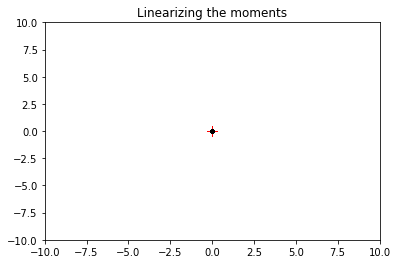

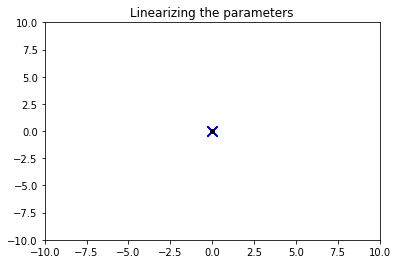

In [31]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)
true_moment_diff = moment_vec_boot - moment_vec
print('True param difference: {}'.format(np.linalg.norm(base_free_par- boot_free_par)))
print('True moment norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

# Use the linear approximation for the parameters, not the moments.
moment_pred_from_params = \
    moment_wrapper.get_moment_vector_from_free(base_free_par + lr_param_diff)
moment_pred_from_params_diff = moment_pred_from_params - moment_vec

# The difference based on a linear approximation to the moments.
# lr_moment_diff = \
#     moment_jac_sp * (param_boot_mat * (np.squeeze(boot_draw) - 1.0))
moment_pred_from_moments_diff = moment_jac_sp * lr_param_diff
    

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, moment_pred_from_params_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])
